## Data Preparation for SD County SIR Model Predictions

- Read data for SD county from database
- compute sizes of susceptible, infected and recovered population from cumulative cases
- save in pytorch format

In [1]:
import sqlalchemy as sal
import pandas as pd

In [3]:
endpoint = "capstone.clihskgj8i7s.us-west-2.rds.amazonaws.com"
user="group3"
db="db1"
pw=open("/home/daniel/Desktop/.awsdb","r").read().rstrip()
engine = sal.create_engine('postgresql://%s:%s@%s/%s' % (user, pw, endpoint, db))

In [4]:
query="""
select c.rdate,c.ncas,c.ctype
from covidlocs l, covidcases c
where l.uid = c.cloc
and l.admin2 = 'San Diego';
"""
tmp=pd.read_sql(query, engine)
cum=tmp[tmp["ctype"] == 'C'][["rdate","ncas"]]
dea=tmp[tmp["ctype"] == 'D']["ncas"].values
dat=tmp[tmp["ctype"] == 'D']["rdate"].values

In [5]:
cum.head()

,rdate,ncas
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0


In [6]:
#Getting SD county's population from DB
query="""
select l.population
from covidlocs l
where l.admin2='San Diego'
"""
sd_pop=pd.read_sql(query, engine).iloc[0,0]
print("Population of San Diego County: %d" % sd_pop)

Population of San Diego County: 3338330


<AxesSubplot:>

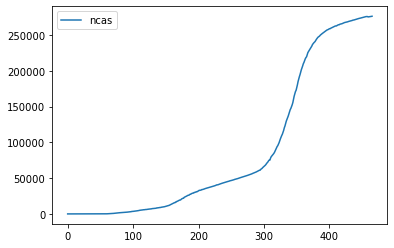

In [7]:
#cumulative cases
cum.plot(y="ncas")#, x="rdate")

Estimating the number of currently active infections based on an assumed recovery time.
The method is explained here:

https://www.cpp.edu/~clange/covid19/Covid19ReportCalifornia.html#9_San_Diego_County

In [8]:
len(cum["ncas"].diff().values)
type(cum["ncas"].values)

numpy.ndarray

In [9]:
import numpy as np

def active_from_cumulative(CU, recovery_time=14):
    assert type(CU) == np.ndarray, "wrong data type"
    nt=len(CU)
    I=np.zeros((nt,), dtype=int)
    newcas=np.diff(CU, prepend=0)
    newcas[0] = 0
    
    for n in range(1,nt):
        if n >= recovery_time:
            newrecov=newcas[n-recovery_time]
        else:
            newrecov=0
        I[n] = I[n-1] + newcas[n] - newrecov
    
    return I

S=sd_pop-cum["ncas"].values
I=active_from_cumulative(cum["ncas"].values)
R=cum["ncas"].values - I

In [13]:
#daily new cases, simply be taking diff
import matplotlib.pyplot as pl
fig,ax=pl.subplots()
ax.plot(dat, cum["ncas"].diff(), label="Daily Diff")
ax.plot(dat,I, label="I")
ax.legend()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


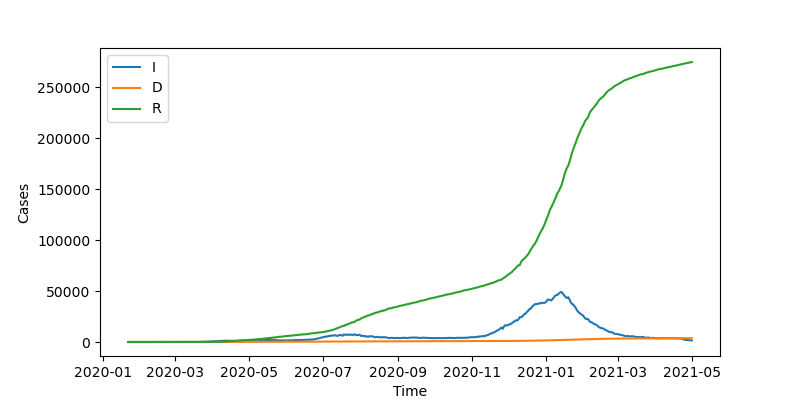

Text(0.5, 0, 'Time')

In [14]:
%matplotlib notebook
import matplotlib.pyplot as pl
fig,ax=pl.subplots(figsize=(8,4))
#dat=range(len(I))
ax.plot(dat, I, label="I")
ax.plot(dat, dea, label="D")
ax.plot(dat, R, label="R")
#ax.plot(dat, S, label="S")
#ax.plot(dat, cum["ncas"], label="cum")
ax.legend(loc="upper left")
ax.set_ylabel("Cases")
ax.set_xlabel("Time")
#ax.plot(dat, S)
#ax.plot(cum.index, cum["ncas"])

In [15]:
import torch as torch

In [34]:
torch.from_numpy(I.reshape(-1,1)).float()

tensor([[0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [2.0000e+00],
        [2.0000e+00],
        [2.0000e+00],
        [2.0000e+00],
        [2.0000e+00],
        [2.0000e+00],
        [2.0000e+00],
        [2.0000e+00],
        [2.0000e+00],
        [2.0000e+00],
        [2.0000e+00],
        [2.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1

In [35]:
sample = torch.cat([torch.from_numpy(S.reshape(-1,1)).float(), 
                     torch.from_numpy(I.reshape(-1,1)).float(), 
                     torch.from_numpy(R.reshape(-1,1)).float()], dim = 1).float()

In [36]:
torch.save(sample, "../MyAutoODE/SIR_data_SD_county.pt")

In [37]:
torch.__version__

'1.4.0'

In [38]:
sample2 = torch.cat([torch.from_numpy(cum["ncas"].values.astype(np.float32).reshape(-1,1))])

In [39]:
torch.save(sample2, "../MyAutoODE/CUM_data_SD_county_v2.pt")

In [ ]:
#sample2